# Deep Learning: Ex.8 - Fine Tuning

Submitted by: [... **Ran Ben-Melech** ...]


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from seaborn import heatmap 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
print(tf.__version__)

2.2.0-rc4


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
def makeLossGraph(history):
    plt.title("loss",fontsize=30)
    plt.xlabel('epochs', fontsize=20)
    plt.ylabel('loss', fontsize=20,rotation='horizontal',position=(0,0.45))
    plt.plot(history.history['loss'],'r',label='train loss',LineWidth=2)
    plt.plot(history.history['val_loss'],'b',label='validation loss',LineWidth=2) 
    plt.grid()
    plt.legend()
    return

In [ ]:
def makeAccGraph(history):
    plt.title("accuracy",fontsize=30)
    plt.xlabel('epochs', fontsize=20)
    plt.ylabel('acc', fontsize=20,rotation='horizontal',position=(0,0.43))
    plt.plot(history.history['accuracy'],'r',LineWidth=2)
    plt.plot(history.history['val_accuracy'],'b',LineWidth=2)
    plt.grid()
    plt.legend()
    plt.show()
    return

In [ ]:
def makeCM(preds):
   
    yhat = np.argmax(preds,axis=1)
    cm = confusion_matrix(test_labels, yhat)
    cm = cm / cm.sum(axis=1)
    plt.figure(figsize=(10,8))
    plt.title("confusion matrix:",fontsize=30)
    heatmap(cm,cmap='Blues',annot=True, fmt='.0%', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label', fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.show()
    return

***
### 1. Create the model

Load the pre-trained VGG16 model without its "classifier top".

- Create a new `Sequential` model
- add the top-less VGG16 as its first layer
- add a new top: `Flatten`(), 256-`Dense` (ReLU), `Dropout`(0.5), 17-`Dense` (Softmax)
- freeze the first layer (the original VGG16)
- print the model summary
- how many trainable parameters you have?

In [6]:
from tensorflow.keras.applications import VGG16

# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows = 224
img_cols = 224 

# Re-loads the VGG16 model without the top or FC layers
vgg = VGG16(weights = 'imagenet', include_top = False,input_shape = (img_rows, img_cols, 3))

for (i,layer) in enumerate(vgg.layers):
    print(str(i),'\t', layer.__class__.__name__, '\t',layer.trainable)


58892288/58889256 [==============================] - 0s 0us/step
0 	 InputLayer 	 True
1 	 Conv2D 	 True
2 	 Conv2D 	 True
3 	 MaxPooling2D 	 True
4 	 Conv2D 	 True
5 	 Conv2D 	 True
6 	 MaxPooling2D 	 True
7 	 Conv2D 	 True
8 	 Conv2D 	 True
9 	 Conv2D 	 True
10 	 MaxPooling2D 	 True
11 	 Conv2D 	 True
12 	 Conv2D 	 True
13 	 Conv2D 	 True
14 	 MaxPooling2D 	 True
15 	 Conv2D 	 True
16 	 Conv2D 	 True
17 	 Conv2D 	 True
18 	 MaxPooling2D 	 True


In [ ]:
def makeVGG16():
    model = Sequential()
    model.add(vgg)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu')) 
    model.add(layers.Dropout(0.5)) 
    model.add(layers.Dense(17, activation='softmax'))
    return model


In [8]:

model=makeVGG16()
model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                4369      
Total params: 21,141,841
Trainable params: 6,427,153
Non-trainable params: 14,714,688
_________________________________________________________________


***
### 2. Train the new top

Train the new model (with the frozen VGG layers) over the flower-17 dataset.

Dataset: either download the dataset from the Moodle link, or if using google colab, use:

 `!git clone https://github.com/bouwkast/Flower-CNN.git`


Use data augmentation for the training. Remeber to rescale the images `rescale=1./255` and to set the `target_size` of the images to (224,224).

(using `RMSProp` you should get 80-90% validatation accuaracy in 20-30 epochs..)

Plot loss and accuracy plots (for both train and validation).

In [9]:
!git clone https://github.com/bouwkast/Flower-CNN.git

Cloning into 'Flower-CNN'...
remote: Enumerating objects: 1572, done.
remote: Total 1572 (delta 0), reused 0 (delta 0), pack-reused 1572
Receiving objects: 100% (1572/1572), 138.13 MiB | 45.72 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [10]:
train_gen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_gen=ImageDataGenerator(rescale=1./255)

data_train=train_gen.flow_from_directory("/content/Flower-CNN/17_flowers/train",target_size=(224, 224),batch_size=64)
data_test=test_gen.flow_from_directory("/content/Flower-CNN/17_flowers/validation",target_size=(224, 224),batch_size=64)


Found 1190 images belonging to 17 classes.
Found 170 images belonging to 17 classes.


In [11]:
model2=makeVGG16()
model2.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
history2 = model2.fit(data_train,steps_per_epoch=2000//64,  epochs=40,validation_data=(data_test),validation_steps=800//64)
model2.save_weights("first_try.h5")

Epoch 1/40
31/31 [==============================] - 32s 1s/step - loss: 4.5195 - accuracy: 0.2145 - val_loss: 1.8074 - val_accuracy: 0.3941
Epoch 2/40
31/31 [==============================] - 32s 1s/step - loss: 1.9975 - accuracy: 0.3742 - val_loss: 1.2972 - val_accuracy: 0.5882
Epoch 3/40
31/31 [==============================] - 32s 1s/step - loss: 1.6294 - accuracy: 0.4826 - val_loss: 0.8073 - val_accuracy: 0.8044
Epoch 4/40
31/31 [==============================] - 31s 1s/step - loss: 1.3323 - accuracy: 0.5725 - val_loss: 0.6558 - val_accuracy: 0.8176
Epoch 5/40
31/31 [==============================] - 31s 1s/step - loss: 1.1444 - accuracy: 0.6325 - val_loss: 0.6956 - val_accuracy: 0.7853
Epoch 6/40
31/31 [==============================] - 31s 1s/step - loss: 1.0046 - accuracy: 0.6752 - val_loss: 0.4266 - val_accuracy: 0.8588
Epoch 7/40
31/31 [==============================] - 31s 991ms/step - loss: 0.8838 - accuracy: 0.7091 - val_loss: 0.5870 - val_accuracy: 0.8529
Epoch 8/40
31/31 

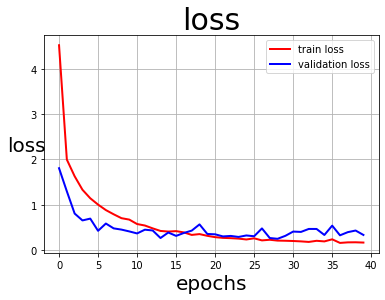

In [12]:
makeLossGraph(history2)

No handles with labels found to put in legend.


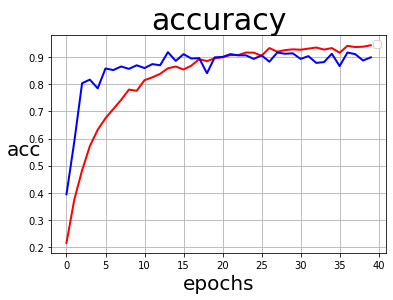

In [13]:
makeAccGraph(history2)

***
### 3. Fine tune all params

At this point, you can 'unfreeze' the VGG layers and continue the training process (with slower learning rate) to get better results.

(using `SGD(lr=0.0001, momentum=0.9)` you should get over 90% validatation accuaracy in 20-30 epochs..)

Plot loss and accuracy plots (for both train and validation).

In [14]:
model2.layers[0].trainable = True
opt=keras.optimizers.SGD(lr=0.0001,momentum=0.9)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history2 = model2.fit(data_train,steps_per_epoch=2000//64,  epochs=40,validation_data=(data_test),validation_steps=800//64)


Epoch 1/40
31/31 [==============================] - 34s 1s/step - loss: 0.0911 - accuracy: 0.9694 - val_loss: 0.2556 - val_accuracy: 0.9397
Epoch 2/40
31/31 [==============================] - 34s 1s/step - loss: 0.1026 - accuracy: 0.9658 - val_loss: 0.2753 - val_accuracy: 0.9118
Epoch 3/40
31/31 [==============================] - 34s 1s/step - loss: 0.0836 - accuracy: 0.9736 - val_loss: 0.2104 - val_accuracy: 0.9412
Epoch 4/40
31/31 [==============================] - 35s 1s/step - loss: 0.0613 - accuracy: 0.9780 - val_loss: 0.2249 - val_accuracy: 0.9426
Epoch 5/40
31/31 [==============================] - 34s 1s/step - loss: 0.0711 - accuracy: 0.9767 - val_loss: 0.1969 - val_accuracy: 0.9338
Epoch 6/40
31/31 [==============================] - 34s 1s/step - loss: 0.0618 - accuracy: 0.9798 - val_loss: 0.3218 - val_accuracy: 0.9235
Epoch 7/40
31/31 [==============================] - 35s 1s/step - loss: 0.0632 - accuracy: 0.9796 - val_loss: 0.2072 - val_accuracy: 0.9353
Epoch 8/40
31/31 [==

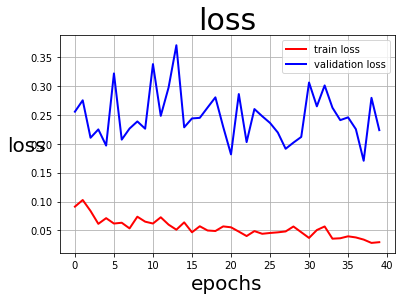

In [15]:
makeLossGraph(history2)

No handles with labels found to put in legend.


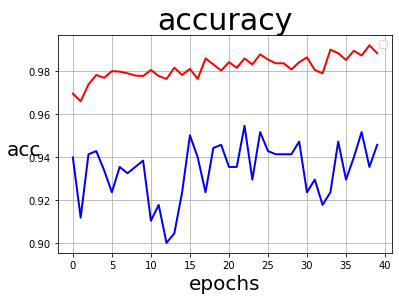

In [16]:
makeAccGraph(history2)

***
## Good Luck!